In [1]:
import os
os.chdir('..')

In [2]:
from tweet_recommendations.utils.clients import get_wcrft2_results_for_text
from tweet_recommendations.embeddings.word2vec import get_w2v_tweet_embedding, load_w2v_model, get_w2v_tweets_embeddings

import pickle
import networkx as nx
import numpy as np
import scipy.spatial.distance
import sklearn.metrics.pairwise
import pandas as pd
import functools

In [3]:
%%time
W2V = load_w2v_model('/mnt/SAMSUNG/models/embeddings/kgr10.plain.skipgram.dim100.neg10.vec')

CPU times: user 3min 3s, sys: 2.1 s, total: 3min 5s
Wall time: 3min 5s


In [4]:
lemmas = get_wcrft2_results_for_text("Ala ma kota, a kot ma Alę. Za to Agnieszka posiada dwa pieski.")
get_w2v_tweet_embedding(lemmas, W2V)

array([-2.07183048e-01, -4.50225890e-01, -1.23955682e-01,  1.12159997e-02,
       -1.76998273e-01,  5.89667484e-02,  2.44616464e-01, -1.74873695e-01,
       -2.28233725e-01,  2.52170891e-01, -1.32351011e-01,  2.86457557e-02,
       -6.36759251e-02,  1.54526129e-01, -1.67579427e-01,  4.38780002e-02,
       -6.55323714e-02,  1.26383126e-01, -1.56067565e-01,  1.00605503e-01,
        9.08714384e-02,  2.06701867e-02, -1.79530736e-02,  7.69727454e-02,
        9.54973791e-03,  1.71648383e-01, -4.78953160e-02, -5.73842525e-01,
       -5.40656269e-01,  6.80634379e-02,  2.37609312e-01, -7.71594942e-02,
       -3.44907522e-01, -6.40556216e-02, -3.43884379e-01,  4.39932570e-02,
       -1.37345776e-01, -1.22633129e-01, -4.00111258e-01,  1.09476903e-02,
       -1.94105297e-01, -1.01804376e-01,  1.05482668e-01,  2.05798119e-01,
        9.09142494e-02,  2.21695796e-01, -2.78363556e-01,  1.26095280e-01,
       -1.80218741e-03,  3.31006944e-01, -1.34967744e-01, -8.82026851e-02,
        1.50050506e-01, -

In [3]:
ft = pd.read_pickle('./data/embeddings/fasttext_embeddings.pkl')
ft.head()

,tweet_id,embeddings
0,1055013541181353987,"[0.066088036, 0.06916399, -0.08772982, 0.02842..."
1,1052688633918963713,"[0.042748816, 0.018327478, -0.026713202, 0.038..."
2,1054102180486172673,"[0.04925826, 0.12695895, -0.08234913, 0.047574..."
3,1051723165829918720,"[0.07929088, 0.052764755, -0.102878, 0.0189335..."
4,1034736277084688384,"[0.05510524, 0.07667969, -0.09653922, 0.048123..."


In [4]:
sk = pd.read_pickle('./data/embeddings/skipgram_embeddings.pkl')
sk.head()

,tweet_id,tweet_embedding
0,1055013541181353987,"[-0.02563778146635741, -0.43154129571281374, -..."
1,1052688633918963713,"[-0.06042357006420692, -0.36830542680053485, 0..."
2,1054102180486172673,"[-0.18836596173544726, -0.36910818586194954, -..."
3,1051723165829918720,"[-0.07193121433790241, -0.3486243937430637, -0..."
4,1034736277084688384,"[-0.21816051351587948, -0.3266038287703584, 0...."


In [52]:
tw = pd.read_pickle('./data/source_data/original_tweets.p')
tw.head()

,contributors,coordinates,created_at,display_text_range,favorite_count,favorited,filter_level,geo,hashtags,id,...,retweet_count,retweeted,scopes,source,text,timestamp_ms,truncated,user,username,withheld_in_countries
0,None,None,2018-10-28 23:35:48+00:00,"[0, 109]",0,False,low,None,"[{'text': 'Warszawa', 'indices': [76, 85]}]",1056691029846491139,...,0,False,NaN,"<a href=""https://echowarszawy.pl"" rel=""nofollo...",KMPSP Warszawa: 23.10.2018 - Drzewo powalone n...,1540769748542,False,965943739809239040,EchoWarszawy,NaN
1,None,None,2018-10-28 23:35:51+00:00,"[48, 290]",0,False,low,None,[],1056691042106400768,...,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@SebNow82 @ChiefRobert2 @Immanuela_Kant @smok0...,1540769751465,True,870751323549040640,dodi6319,NaN
2,None,None,2018-10-28 23:35:56+00:00,"[50, 330]",0,False,low,None,[],1056691065200304128,...,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@rafalch2 @KLubnauer @Nowoczesna @wlodekczarza...,1540769756971,True,1025517195223281664,Fiona11701355,NaN
3,None,None,2018-10-28 23:35:59+00:00,"[20, 72]",0,False,low,None,[],1056691075727982592,...,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@wkrawcz1 @pisorgpl W PiS to normalne. Wszyscy...,1540769759481,False,811556244892872704,Paul4Anka,NaN
4,None,None,2018-10-28 23:36:10+00:00,NaN,0,False,low,None,[],1056691121097752576,...,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Czasami żałuję, że Krysia mnie zablokowała😘",1540769770298,False,1004022955045728256,JanKiebasa3,NaN


In [6]:
twid = 1055013541181353987

In [7]:
tw[tw['id'] == 1055013541181353987].iloc[0].text

'@elyphend @MikiWrobelek_ a była to kleska? Tusk i takl był przesadzony przy poparciu Makreli, a teraz, gdy nan nim Angole i inni wieszają psy - PL może jasno pokazywać: to nie był kandydat PL, pretensje do DE. A przyszły europarlament będzie radykalnie inny...'

In [8]:
lemmas = get_wcrft2_results_for_text(tw[tw['id'] == twid].iloc[0].text)
print(lemmas)
emb = get_w2v_tweet_embedding(['ludzki', 'pan'], W2V)

['@', 'elyphend', '@', 'MikiWrobelek', '_', 'a', 'być', 'to', 'kleska', '?', 'Tusk', 'i', 'takl', 'być', 'przesadzić', 'przy', 'poparcie', 'makrela', ',', 'a', 'teraz', ',', 'gdy', 'nan', 'on', 'Angol', 'i', 'inny', 'wieszać', 'pies', '-', 'pl', 'móc', 'jasno', 'pokazywać', ':', 'to', 'nie', 'być', 'kandydat', 'pl', ',', 'pretensja', 'do', 'de', '.', 'a', 'przyjść', 'europarlament', 'być', 'radykalnie', 'inny', '.', '.', '.']


NameError: name 'W2V' is not defined

In [9]:
def cosine_similarity(x, y):
    similarity = sklearn.metrics.pairwise.cosine_similarity(x, y)
    ang_dist = np.arccos(similarity) / np.pi
    ang_sim = 1 - ang_dist
    return ang_sim

In [10]:

def recommend_for_embedding(embedding, hashtags_df, config):
    embedding_name = config['embedding_name']
    popularity_measure = config['popularity_measure']
    popularity_to_similarity_ratio = config['popularity_to_similarity_ratio']
    K = config['K']

    similarities = cosine_similarity(embedding.reshape(1,-1), 
                                     np.vstack(hashtags_df[embedding_name])).reshape(-1)
    similarities = (similarities - similarities.min()) / (similarities.max() - similarities.min())
    
    ranks = hashtags_df[popularity_measure].values
    ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())
    
    similarities_ranks_mix = similarities + (popularity_to_similarity_ratio * ranks)
    
    topK = similarities_ranks_mix.argsort()[-K:][::-1]
    return list(topK)    

In [486]:
np.asarray([1,4,3,2]).argsort()[-2:][::-1]

array([1, 2])

In [11]:
def recommend(text, hashtags_df, config):
    if config['is_input_embedding']:
        embedding = text
    else:
        w2v_function = config['w2v_function']
        lemmas = get_wcrft2_results_for_text(text)
        embedding = w2v_function(lemmas)
    return recommend_for_embedding(embedding, hashtags_df, config)

In [7]:
with open('./data/graphs/train_graph.p','rb') as f:
    G = pickle.load(f)

In [13]:
gg = 1056697658499313664

In [14]:
tweet = tw[tw['id'] == gg].iloc[0]
tweet

contributors                                                              None
coordinates                                                               None
created_at                                           2018-10-29 00:02:08+00:00
display_text_range                                                    [0, 161]
favorite_count                                                               1
favorited                                                                False
filter_level                                                               low
geo                                                                       None
hashtags                     [{'text': 'bardzozłazmiana', 'indices': [59, 7...
id                                                         1056697658499313664
id_str                                                     1056697658499313664
in_reply_to_screen_name                                                   None
in_reply_to_status_id                               

In [15]:
emb = sk[sk['tweet_id'] == str(gg)].iloc[0]['tweet_embedding']

In [8]:
hashtags = [{'hashtag': node, **G.nodes[node]} for node in G.nodes if G.nodes[node]['node_type'] == 'hashtag']
hashtags = pd.DataFrame(hashtags)
len(hashtags)

13476

In [9]:
hashtags.head()

,fasttext,hashtag,mean_retweets,node_type,pagerank,skipgram
0,"[0.046705928, 0.03309554, -0.10903065, 0.03073...",Warszawa,2.571078,hashtag,0.014377,"[-0.05190280179166349, -0.3211154559358569, -0..."
1,"[0.05721787, 0.010905963, -0.0857292, 0.029427...",PiS,5.436228,hashtag,0.018450,"[-0.07250170281078769, -0.3559423050221444, -0..."
2,"[-0.012052198, 0.08327832, -0.120274894, 0.062...",pogoda,0.051630,hashtag,0.001213,"[-0.212486921761243, -0.31912716791471457, -0...."
3,"[-0.015956132, 0.08419912, -0.121734515, 0.065...",RPi,0.000000,hashtag,0.001094,"[-0.22681104476860967, -0.3198441901375714, -0..."
4,"[-0.015956132, 0.08419912, -0.121734515, 0.065...",smolec,0.000000,hashtag,0.001094,"[-0.22681104476860967, -0.3198441901375714, -0..."


In [18]:
skipgrams = np.vstack(hashtags.skipgram)

In [19]:
similarities = cosine_similarity(emb.reshape(1,-1), skipgrams).reshape(-1)
similarities = (similarities - similarities.min()) / (similarities.max() - similarities.min())
ranks = hashtags.mean_retweets.values
ranks = hashtags.pagerank.values
ranks = (ranks - ranks.min()) / (ranks.max() - ranks.min())

In [22]:
topK = recommend_for_embedding(sk[sk['tweet_id'] == str(gg)].iloc[0]['tweet_embedding'], 
                        hashtags, 
                        {'K': 100, 
                         'w2v_function': None,#functools.partial(get_w2v_tweet_embedding, w2v_model=W2V),
                         'embedding_name': 'skipgram',
                         'popularity_measure': 'mean_retweets',
                         'popularity_to_similarity_ratio': 0.4,
                         'is_input_embedding': False})

In [23]:
pred = []
for ind in topK:
    pred.append(hashtags.iloc[ind].hashtag)
pred

['mówprawę',
 'AferyPO',
 'DebataWarszawa',
 'DebataWarszawaska',
 'POLBRA',
 'LIDER',
 'stopPislmizacjiPolski',
 'KOBIETY',
 'cofampoparciepis',
 'dotrzymujmyslowa',
 'PanemEtCircenses',
 'Upaina',
 'HALO',
 'POLSKA',
 'odnowa',
 'zaczelosie',
 'WCzarzasty',
 'Vergüenza',
 'elecciones',
 'targowica',
 'PrzekonajSasiada',
 'NieDzwońcie',
 'NiePISzęSię',
 'KomunaCiągleŻywa',
 'zdrajcy',
 'kropladrazyskałę',
 'warszawy',
 'miskaryzuPlus',
 'dasię',
 'ZLODZIEI',
 'korkidlatwitterowiczow',
 'Hanna',
 'Rumbleinthejungle',
 'STOP',
 'Zwycięzcy',
 'CzarniRadom',
 'ENEAdodałaenergii',
 'CzyścicieleKamienic',
 'wyborywKrakowie',
 'Noakowskiego16',
 'złodzieje',
 'PISOSZUKAŁ',
 'ZŁAZMIANA',
 'ZDRAJCY',
 'pisoszukał',
 'BurnTheStageMovie',
 'bardzozłazmiana',
 'KukPisKler',
 'STOPSocjalizm',
 'pisbolszewickim',
 'MuremZaPJK',
 'dobrywybor',
 'PiSOUT',
 'KRAKOW',
 'korki',
 '2złZaWpis',
 'Jedziemy',
 'PISdeweloperzy',
 'PRAWNIK',
 'TargowiceNaTablice',
 'News',
 'Prawi',
 'lech',
 'moc',
 'koniecH

In [24]:
real_hashtags = [h['text'] for h in tweet.hashtags]
print(real_hashtags)

['bardzozłazmiana', 'złazmiana', 'targowica', 'pisoszukał', 'cofampoparciepis', 'dotrzymujemysłowa', 'dobrazmiana']


In [25]:
set(real_hashtags).intersection(set(pred))

{'bardzozłazmiana',
 'cofampoparciepis',
 'dotrzymujemysłowa',
 'pisoszukał',
 'targowica',
 'złazmiana'}

In [27]:
CFG = {'K': 100, 
       'w2v_function': None, #functools.partial(get_w2v_tweet_embedding, w2v_model=W2V),
       'embedding_name': 'skipgram',
       'popularity_measure': 'mean_retweets',
       'popularity_to_similarity_ratio': 0.4,
       'is_input_embedding': True}

In [28]:
list(hashtags['hashtag'].iloc[recommend_for_embedding(emb, hashtags, CFG)])

['mówprawę',
 'AferyPO',
 'DebataWarszawa',
 'DebataWarszawaska',
 'POLBRA',
 'LIDER',
 'stopPislmizacjiPolski',
 'KOBIETY',
 'cofampoparciepis',
 'dotrzymujmyslowa',
 'PanemEtCircenses',
 'Upaina',
 'HALO',
 'POLSKA',
 'odnowa',
 'zaczelosie',
 'WCzarzasty',
 'Vergüenza',
 'elecciones',
 'targowica',
 'PrzekonajSasiada',
 'NieDzwońcie',
 'NiePISzęSię',
 'KomunaCiągleŻywa',
 'zdrajcy',
 'kropladrazyskałę',
 'warszawy',
 'miskaryzuPlus',
 'dasię',
 'ZLODZIEI',
 'korkidlatwitterowiczow',
 'Hanna',
 'Rumbleinthejungle',
 'STOP',
 'Zwycięzcy',
 'CzarniRadom',
 'ENEAdodałaenergii',
 'CzyścicieleKamienic',
 'wyborywKrakowie',
 'Noakowskiego16',
 'złodzieje',
 'PISOSZUKAŁ',
 'ZŁAZMIANA',
 'ZDRAJCY',
 'pisoszukał',
 'BurnTheStageMovie',
 'bardzozłazmiana',
 'KukPisKler',
 'STOPSocjalizm',
 'pisbolszewickim',
 'MuremZaPJK',
 'dobrywybor',
 'PiSOUT',
 'KRAKOW',
 'korki',
 '2złZaWpis',
 'Jedziemy',
 'PISdeweloperzy',
 'PRAWNIK',
 'TargowiceNaTablice',
 'News',
 'Prawi',
 'lech',
 'moc',
 'koniecH

In [29]:
from tweet_recommendations.recommendation import recommend_for_embedding as rfe
from tweet_recommendations.recommendation import recommend_with_config as rwc

In [32]:
rfe(emb, hashtags, CFG)

['mówprawę',
 'AferyPO',
 'DebataWarszawa',
 'DebataWarszawaska',
 'POLBRA',
 'LIDER',
 'stopPislmizacjiPolski',
 'KOBIETY',
 'cofampoparciepis',
 'dotrzymujmyslowa',
 'PanemEtCircenses',
 'Upaina',
 'HALO',
 'POLSKA',
 'odnowa',
 'zaczelosie',
 'WCzarzasty',
 'Vergüenza',
 'elecciones',
 'targowica',
 'PrzekonajSasiada',
 'NieDzwońcie',
 'NiePISzęSię',
 'KomunaCiągleŻywa',
 'zdrajcy',
 'kropladrazyskałę',
 'warszawy',
 'miskaryzuPlus',
 'dasię',
 'ZLODZIEI',
 'korkidlatwitterowiczow',
 'Hanna',
 'Rumbleinthejungle',
 'STOP',
 'Zwycięzcy',
 'CzarniRadom',
 'ENEAdodałaenergii',
 'CzyścicieleKamienic',
 'wyborywKrakowie',
 'Noakowskiego16',
 'złodzieje',
 'PISOSZUKAŁ',
 'ZŁAZMIANA',
 'ZDRAJCY',
 'pisoszukał',
 'BurnTheStageMovie',
 'bardzozłazmiana',
 'KukPisKler',
 'STOPSocjalizm',
 'pisbolszewickim',
 'MuremZaPJK',
 'dobrywybor',
 'PiSOUT',
 'KRAKOW',
 'korki',
 '2złZaWpis',
 'Jedziemy',
 'PISdeweloperzy',
 'PRAWNIK',
 'TargowiceNaTablice',
 'News',
 'Prawi',
 'lech',
 'moc',
 'koniecH

In [36]:
rwc(emb, hashtags, CFG)

['mówprawę',
 'AferyPO',
 'DebataWarszawa',
 'DebataWarszawaska',
 'POLBRA',
 'LIDER',
 'stopPislmizacjiPolski',
 'KOBIETY',
 'cofampoparciepis',
 'dotrzymujmyslowa',
 'PanemEtCircenses',
 'Upaina',
 'HALO',
 'POLSKA',
 'odnowa',
 'zaczelosie',
 'WCzarzasty',
 'Vergüenza',
 'elecciones',
 'targowica',
 'PrzekonajSasiada',
 'NieDzwońcie',
 'NiePISzęSię',
 'KomunaCiągleŻywa',
 'zdrajcy',
 'kropladrazyskałę',
 'warszawy',
 'miskaryzuPlus',
 'dasię',
 'ZLODZIEI',
 'korkidlatwitterowiczow',
 'Hanna',
 'Rumbleinthejungle',
 'STOP',
 'Zwycięzcy',
 'CzarniRadom',
 'ENEAdodałaenergii',
 'CzyścicieleKamienic',
 'wyborywKrakowie',
 'Noakowskiego16',
 'złodzieje',
 'PISOSZUKAŁ',
 'ZŁAZMIANA',
 'ZDRAJCY',
 'pisoszukał',
 'BurnTheStageMovie',
 'bardzozłazmiana',
 'KukPisKler',
 'STOPSocjalizm',
 'pisbolszewickim',
 'MuremZaPJK',
 'dobrywybor',
 'PiSOUT',
 'KRAKOW',
 'korki',
 '2złZaWpis',
 'Jedziemy',
 'PISdeweloperzy',
 'PRAWNIK',
 'TargowiceNaTablice',
 'News',
 'Prawi',
 'lech',
 'moc',
 'koniecH

In [35]:
rwc(emb, hashtags, CFG) == rfe(emb, hashtags, CFG)

True

In [5]:
from tweet_recommendations.recommendation import recommend_with_config

In [147]:
config = {'K': 10,
          'w2v_function': functools.partial(get_w2v_tweet_embedding,
                                            w2v_model=W2V),
          'embedding_name': 'skipgram',
          'popularity_measure': 'pagerank',
          'popularity_to_similarity_ratio': 0.1,
          'is_input_embedding': False}

In [148]:
recommend_with_config('Sprzedam Opla.', hashtags, config)

['obiecankicacanki',
 'GaleriaBankowa',
 'samochodowe',
 'kredyty',
 'szybkileasing',
 'lubuskie',
 'tramwaje',
 'Peugeot',
 'DW580',
 'show']

In [38]:
recommend_with_config('Wiozę szwagra na wybory.', hashtags, config)

['nigdywięcejj',
 'WybierzmyPrzyszlosc',
 'weszłofm',
 'Najsztub',
 'WinaPiS',
 'ciechanowianie',
 'zacisze',
 'ZabraćMałpieBrzytwę',
 'idziemy',
 'idę']

In [24]:
hashtags.columns

Index(['fasttext', 'hashtag', 'mean_retweets', 'node_type', 'pagerank',
       'skipgram'],
      dtype='object')

In [51]:
'wiozęszwagranawybory' in hashtags.hashtag.str.lower().values

True

In [48]:
hashtags[hashtags.hashtag.str.lower().apply(lambda x: 'wiozęszwagranawybory' in x)]

,fasttext,hashtag,mean_retweets,node_type,pagerank,skipgram
12700,"[0.039843366, -0.02861123, -0.07706344, 0.0178...",WiozęSzwagraNaWybory,0.0,hashtag,0.000008,"[-0.10240892391108597, -0.24285199716687203, 0..."


In [87]:
szwagier = tw[tw.hashtags.apply(lambda htgs: any(x['text'].lower() == 'wiozęszwagranawybory' for x in htgs))].iloc[0]
tx = szwagier.text
print(tx)

@jowitawiatrak 1. Msza Św. na 10
2. Śniadanie z rodziną
3. #IdziemyNaWybory 
4. #WiozęSzwagraNaWybory
5. Cała masa miłych zdarzeń 😉
6. Wieczorem wspólne świętowanie zwycięstwa @pisorgpl w #wybory2018 🇵🇱💯


In [88]:
szwagier.retweet_count

0

In [91]:
recommend_with_config(tx, hashtags, {'K': 10,
                              'w2v_function': functools.partial(get_w2v_tweet_embedding,
                                            w2v_model=W2V),
                              'embedding_name': 'skipgram',
                              'popularity_measure': 'pagerank',
                              'popularity_to_similarity_ratio': 0.0,
                              'is_input_embedding': False})

Key 'jowitawiatrak' not found in w2v dict
Key 'IdziemyNaWybory' not found in w2v dict
Key 'WiozęSzwagraNaWybory' not found in w2v dict
Key 'pisorgpl' not found in w2v dict


['WiozęSzwagraNaWybory',
 'KantarPublic',
 'PurpleARMYDay',
 'goONICO',
 'Wrocław',
 'hessenwahl2018',
 'AmbitnaWarszawa',
 'wyboryolsztyn18',
 'okw',
 'JednaPartia']

In [101]:
recommend_with_config(tx, hashtags, 
                      config={'K': 10,
                              'w2v_function': functools.partial(get_w2v_tweet_embedding,
                                            w2v_model=W2V),
                              'embedding_name': 'skipgram',
                              'popularity_measure': 'pagerank',
                              'popularity_to_similarity_ratio': 0.5,
                              'is_input_embedding': False})

Key 'jowitawiatrak' not found in w2v dict
Key 'IdziemyNaWybory' not found in w2v dict
Key 'WiozęSzwagraNaWybory' not found in w2v dict
Key 'pisorgpl' not found in w2v dict


['wyborysamorzadowe2018',
 'wybory2018',
 'Warszawa',
 'PiS',
 'wyborysamorządowe2018',
 'Wrocław',
 'KoalicjaObywatelska',
 'Wybory2018',
 'warszawa',
 'wyborysamorzadowe']

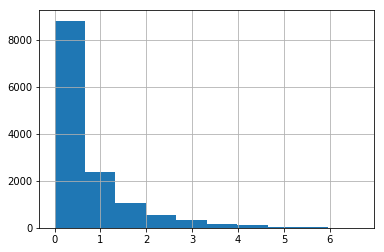

In [115]:
import matplotlib.pyplot as plt
np.log1p(hashtags.mean_retweets).hist(bins=10)
plt.show()

In [155]:
recommend_with_config('Namysłów', hashtags, 
                      config={'K': 10,
                              'w2v_function': functools.partial(get_w2v_tweet_embedding,
                                            w2v_model=W2V),
                              'embedding_name': 'skipgram',
                              'popularity_measure': 'mean_retweets',
                              'popularity_to_similarity_ratio': 0.1,
                              'is_input_embedding': False})

['RobertKrupowicz',
 'Cheł',
 'Oława',
 'wójtów',
 'Skorzewo',
 'Swierczow',
 'Zebowice',
 'Pawlowiczki',
 'JulianKruszynski',
 'NoweWarpno']